# Matrix factorization for recommendation problems

In the previous lesson, we trained a model to predict the ratings assigned to movies by users in the [MovieLens dataset](https://www.kaggle.com/grouplens/movielens-20m-dataset/home). As a reminder the model looked something like this:

**TODO: diagram**

We look up an embedding vector for the movie and user, concatenate them together. Then we add some hidden layers. Finally these come together at a single output node to predict a rating.

In this lesson, I'll show a simpler architecture for solving the same problem: **matrix factorization**. And simpler can be a very good thing! Sometimes a simple model will converge quickly to an adequate solution, where a more complicated model might overfit or fail to converge.

Here's what our matrix factorization model will look like:

**TODO: diagram**


# Dot product?

Let's review a bit of math. If you're a linear algebra pro, feel free to skip this section.

The dot product of two length-$n$ vectors $\mathbf{a}$ and $\mathbf{b}$ is defined as:

$$\mathbf{a}\cdot\mathbf{b}=\sum_{i=1}^n a_ib_i=a_1b_1+a_2b_2+\cdots+a_nb_n$$

The result is a single scalar number (not a vector). In this case, that number will be our predicted rating.

The dot product is only defined for vectors *of the same length*. This means we need to use the same size for movie embeddings and user embeddings.

As an example, suppose we've trained embeddings of size 4, and the movie *Twister* is represented by the vector:

$$\mathbf{m_{Twister}} = \begin{bmatrix} 1.0 & -0.5 & 0.3 & -0.1 \end{bmatrix} $$

And the user Stanley is represented by:

$$\mathbf{u_{Stanley}} = \begin{bmatrix} -0.2 & 1.5 & -0.1 & 0.9 \end{bmatrix} $$

What rating do we think Stanley will give to *Twister*? We can calculate it as:

**TODO: fix formatting**

\begin{align}
\ \mathbf{m_{Twister}} \cdot \mathbf{u_{Stanley}} &= 2.3 * -0.2 + -0.5 * 1.5 + 0.6 * -0.1 + -0.1 * 0.9 + 3.5 \\
&= 2.14
\end{align}

> *Note:* Like yesterday, we'll be be training on a 'centered' version of the rating column - one where we've subtracted the overall average rating from each value. This is why we need to add 3.5 (the average rating) to get our predicted rating on the original 0.5 - 5 star scale.

# Why?

There's an intuitive interpretation that supports the decision to combine our embedding vectors in this way. Suppose the dimensions of our movie embedding space correspond to the following axes of variation:

- Dimension 1: How action-packed?
- Dimension 2: How romantic?
- Dimension 3: How mature is the intended audience?
- Dimension 4: How funny is it?

Hence, *Twister*, an action-packed disaster movie, has a positive value of 1.0 for $m_1$.

What does this imply about the meaning of our user vectors? Remember that $m_1 * u_1$ is one of the terms we add up to get our predicted rating. So if $u_1$ is 1.0, it will increase our predicted rating by 1 star (vs. $u_1 = 0$). If $u_1$ is .5, our predicted rating goes up half a star. If $u_1$ is -1, our predicted rating goes down a star.

In plain terms $u_1$ tells us 'how does this user feel about action?'. Do they love it? Hate it? Or are they indifferent?

Stanley's vector tells us he's a big fan of romance and comedy, and slightly dislikes action and mature content. What if we give him a movie that's similar to the last one except that it has lots of romance?

$$\mathbf{m_{Titanic}} = \begin{bmatrix} 1.9 & 1.1 & 0.5 & -0.3 \end{bmatrix} $$

It's not hard to predict how this affects our rating output. We're giving Stanley more of what he likes, so his predicted rating increases.

\begin{align}
\ \mathbf{m_{Titanic}} \cdot \mathbf{u_{Stanley}} &= b + 2.3 * -0.2 + -0.5 * 1.5 + 0.6 * -0.1 + -0.1 * 0.9 \\
&= 3.5 + 2.3 * -0.2 + -0.5 * 1.5 + 0.6 * -0.1 + -0.1 * 0.9 \\
&= 4.62
\end{align}

> **Aside:** In practice, the meaning of the dimensions of our movie embeddings will not be quite so clear-cut, but it remains true that the meaning of our movie embedding space and user embedding space are fundamentally tied together: $u_i$ will always represent "how much does this user like movies that have the quality represented by $m_i$?". (Hopefully this also gives some more intuition for why the movie embedding space and user embedding space have to be the same size for this technique.)


# Implementing it


In [1]:
#$HIDE$
# Setup. Import libraries and load dataframes for Movielens data.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random

input_dir = '../input/movielens_preprocessed'
ratings_path = os.path.join(input_dir, 'rating.csv')

ratings_df = pd.read_csv(ratings_path, usecols=['userId', 'movieId', 'rating', 'y'])
df = ratings_df
df = df.sample(frac=1)

movies_df = pd.read_csv(os.path.join(input_dir, 'movie.csv'), usecols=['movieId', 'title'])

The code to create this model is similar to the code we wrote in the previous lesson, except I combine the outputs of the user and movie embedding layers using a `Dot` layer (instead of concatenating them, and piling on dense layers).

In [2]:
movie_embedding_size = user_embedding_size = 8

# Each instance consists of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])
out = keras.layers.Flatten()(dotted)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(0.005),
    loss='MSE',
    metrics=['MAE'],
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         1107952     user_id[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 8)         213952      movie_id[0][0]                   
__________________________________________________________________________________________________
dot (Dot) 

Let's train it.

In [3]:
tf.set_random_seed(1); np.random.seed(1); random.seed(1)
history = model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=10**4,
    epochs=10,
    verbose=2,
    validation_split=.05,
);

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/10
 - 50s - loss: 1.0370 - mean_absolute_error: 0.7703 - val_loss: 0.7511 - val_mean_absolute_error: 0.6628
Epoch 2/10
 - 49s - loss: 0.7058 - mean_absolute_error: 0.6422 - val_loss: 0.6897 - val_mean_absolute_error: 0.6343
Epoch 3/10
 - 49s - loss: 0.6485 - mean_absolute_error: 0.6152 - val_loss: 0.6561 - val_mean_absolute_error: 0.6178
Epoch 4/10
 - 55s - loss: 0.6135 - mean_absolute_error: 0.5982 - val_loss: 0.6421 - val_mean_absolute_error: 0.6107
Epoch 5/10
 - 55s - loss: 0.5964 - mean_absolute_error: 0.5898 - val_loss: 0.6362 - val_mean_absolute_error: 0.6076
Epoch 6/10
 - 52s - loss: 0.5876 - mean_absolute_error: 0.5855 - val_loss: 0.6346 - val_mean_absolute_error: 0.6065
Epoch 7/10
 - 52s - loss: 0.5826 - mean_absolute_error: 0.5830 - val_loss: 0.6337 - val_mean_absolute_error: 0.6060
Epoch 8/10
 - 51s - loss: 0.5794 - mean_absolute_error: 0.5814 - val_loss: 0.6336 - val_mean_absolute_error: 0.6058
Epoch 9/10
 - 52s

In [4]:
model.save('factorization_model.h5')

Let's compare the error over time for this model to the deep neural net we trained yesterday:

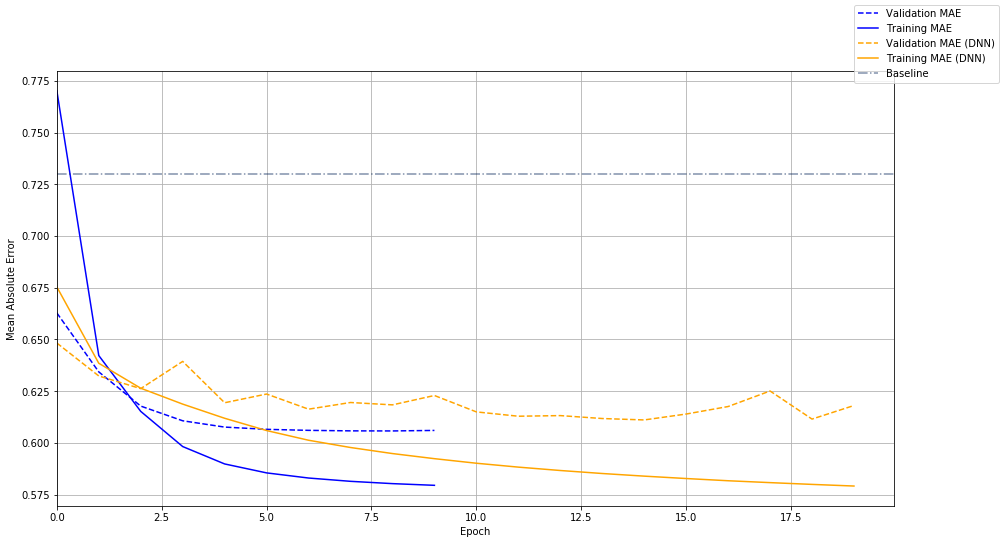

In [13]:
#$HIDE_INPUT$
hdf = pd.read_csv('history-1.csv')

fig, ax = plt.subplots(figsize=(15, 8))
c1 = 'blue'
ax.plot(history.epoch, history.history['val_mean_absolute_error'], '--', label='Validation MAE', color=c1)
ax.plot(history.epoch, history.history['mean_absolute_error'], label='Training MAE', color=c1)

c2 = 'orange'
ax.plot(hdf.epoch, hdf.val_mae, '--', label='Validation MAE (DNN)', color=c2)
ax.plot(hdf.epoch, hdf.train_mae, label='Training MAE (DNN)', color=c2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0)
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='-.', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

The simple model wins! Our new model (in blue) achieves a better error rate on the validation data, and it flattens out much faster. Our validation error over time also has a much smoother shape.

However, even though our embeddings are fairly small, both models suffer from some obvious overfitting. That is,  the error on the training set - the solid lines - is significantly better than on the unseen data. We'll work on addressing that very soon in the exercise.

**TODO: run for same number of epochs**

# Your turn

_______

In [ ]:
# Scratch space below - please ignore

In [1]:
df.head()
movies_df.head()
dfm = df.merge(movies_df, on='movieId')[ ['userId', 'movieId', 'rating', 'title'] ]
dfm.head()

NameError: name 'df' is not defined

In [19]:
ratings_per_user = df.groupby('userId').size()

In [ ]:
"""UIDs:
112287 (American Beauty, The Notebook, Mean Girls, The Devil Wears Prada)
69106 (Terminator 2, Toy Story, WALL-E, Days of Thunder, Star Wars, The Matrix)
83421 (The Godfather, The Shawshank Redemption, Casino, Casablanca)
"""

In [31]:
uid = ratings_per_user[ratings_per_user < 40].sample(1, random_state=11
                                                    ).index[0]
user_ratings = dfm[dfm.userId==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f})".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
user_ratings.sort_values(by='rating', ascending=False)

User #83421 has rated 26 movies (avg. rating = 3.3)


,userId,movieId,rating,title
6410692,83421,1195,5.0,The Godfather: Part II
2799635,83421,315,4.5,The Shawshank Redemption
7706374,83421,15,4.5,Casino
1055793,83421,895,4.0,Casablanca
14407106,83421,2457,4.0,"Lock, Stock & Two Smoking Barrels"
13961655,83421,2193,4.0,Ronin
13876065,83421,427,4.0,Carlito's Way
16072267,83421,1221,4.0,"Femme Nikita, La (Nikita)"
3926026,83421,3359,4.0,"Good Morning, Vietnam"
6897101,83421,12206,3.5,No Country for Old Men


In [47]:
nratings = df.groupby('movieId').size()
movies.loc[nratings.index, 'n_ratings'] = nratings

movies[
    movies.title.str.contains(' III')
    & (movies.n_ratings >= 1000)
].iloc[:30]

,movieId,title,n_ratings
40,40,Richard III,4689
124,124,The NeverEnding Story III,1376
401,401,Highlander III: The Sorcerer (a.k.a. Highlande...,3554
416,416,Beverly Hills Cop III,14934
846,846,Supercop (Police Story 3: Supercop) (Jing cha ...,2527
1344,1344,Star Trek III: The Search for Spock,10813
1900,1900,Halloween III: Season of the Witch,1060
1912,1912,Poltergeist III,1107
1915,1915,The Exorcist III,1049
1928,1928,Back to the Future Part III,19724


In [1]:
movies[
    movies.title.str.contains('Saw')
].head(15)

NameError: name 'movies' is not defined